# This jupyter is self contained

In [1]:
#| default_exp learner

In [2]:
#|export
import math,torch,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from operator import attrgetter
from functools import partial
from copy import copy
from torch import optim
import torch.nn.functional as F
import matplotlib as mpl
import torchvision.transforms.functional as TF
from torch import nn, tensor
from datasets import load_dataset
from torch.utils.data import DataLoader
from torchmetrics.classification import MulticlassAccuracy
from torchmetrics.aggregation import MeanMetric
from operator import itemgetter
from torch.utils.data import default_collate
from fastprogress import progress_bar,master_bar

# Lib methods

In [3]:
#|export
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b):
        return get(default_collate(b))
    return _f

@inplace
def transformi(b): 
    b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

class DataLoaders:
    def __init__(self, train_data_loader, valid_data_loader):
        self.train = train_data_loader
        self.valid = valid_data_loader

    @classmethod # static method
    def from_datasetDict(cls, datasetDict, batch_size): #, as_tuple=True):
        '''        
        static method with cls allows the instanciation of the class: calls self.__init__
        May use multiple workers
        Do not send anything to device here cuz huge overload
        '''        
        return cls(*[DataLoader(ds, batch_size, collate_fn=collate_dict(ds)) for ds in datasetDict.values()])

def get_model(): 
    m,nh = 28*28,50
    return nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))    

def to_cpu(x): # optional here it was used because torchmetrics was bugged
    if isinstance(x, Mapping): 
        return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): 
        return [to_cpu(o) for o in x]
    if isinstance(x, tuple): 
        return tuple(to_cpu(list(x)))
    res = x.detach().cpu()
    return res.float() if res.dtype==torch.float16 else res

def to_device(x, device=None): 
    if device is None:
        device = "mps" if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'              
    if isinstance(x, Mapping):
        return {k:v.to(device) for k,v in x.items()}
    return type(x)(o.to(device) for o in x)

# Data

In [4]:
x,y = 'image','label'
dsd = load_dataset("fashion_mnist")
bs = 1024
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_datasetDict(tds, bs)
dt = dls.train
num_classes = ((tensor(dsd['train'][y]).unique()).max()+1).item()
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 784]), tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5]))

# Updated versions since lesson8
After the lesson we noticed that contextlib.context_manager has a surprising "feature" which doesn't let us raise an exception before the yield. Therefore we've replaced the context manager with a decorator in this updated version of Learner. We have also added a few more callbacks in one_epoch().

with_cbs is a decorator. A decorator takes as input a function (the function defd below the decorator) and returns another 
function. When the defd function is called, the funct returned by the decorator is executed, thus modifying the behavior of the original function.

In [5]:
#|export
class with_cbs:
    '''
    When the function decorated is called, with_cbs is instaciated
    The arg of the decorator in calle is with_cbs ctor arg: "method_name"
    '''
    def __init__(self, method_name): 
        self.method_name = method_name
        
    def __call__(self, f):        
        '''
        When the function decorated is called, and the __init__ call is completed, the __call__ method is executed.
        It returns another function that is executed in place of the original funct. 
        It modifies the behavior of the original funct as:
        1) calls learner.callback(when_to_execute_cb_wrt_{method_name})
            which loops over all callbacks registered in the learner and 
                calls all "when_to_execute_cb_wrt_{method_name}" methods
            e.g., "before_fit", "before_epoch", "before_batch" etc methods.
        2) calls original function
        3) executes all callbacks registered in the learner that have to be executed ".after_{method_name}"
            eg "after_fit", "after_epoch", "after_batch" etc methods.        
        '''        
        def _f(learner, *args, **kwargs): # Learner object ref + generic signature to forward all args/kwargs of original f
            '''
            A generic original function of the Learner class has the following signature:
                def func_name(self, *args, **kwargs)
                e.g.,: def _fit(self, train, valid)
            That's why learner in the signature of this function is the reference to the calling Learner obj
            '''            
            try:
                learner.callback(f'before_{self.method_name}')  
                f(learner, *args, **kwargs)
                learner.callback(f'after_{self.method_name}')
            except globals()[f'Cancel{self.method_name.title()}Exception']: # globals() = dict of global symbols
                pass # idea: if we raise a particular exception we have control of Learner.method_name() execution
            finally: 
                learner.callback(f'cleanup_{self.method_name}')
        return _f

Everything is always set as self.foo such to make everything modifiable via callbacks, since callbacks have a reference to this learner.

Learner obj and Callbacks obj are very coupled but high performance cuz of direct access across each other.

Code design: exceptions as control flow

In [6]:
#|export
class Learner():
    '''
    An object that contains and executes all the possible operations related to a pytorch model
    It requires the implementation of a TrainCB callback object.    
    '''
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        fc.store_attr()
        cbs = fc.L(cbs) # creates a list that can be indexed with list of idxs (as masking)
    
    def __getattr__(self, name):
        '''
        __getattr__ is called iif the name is not registered in the class.
        
        Called when one of: ['predict', 'get_loss', 'backward', 'step', 'zero_grad'] is accessed via self 
        and is not defined as class method. 
        It calls: e.g., self.predict or self.get_loss
        returns the function: self.callback executed with "name" as firt input arg:
            self.callback(name)
        first it is resolved the access to data-member (self.predict or self.get_loss) 
        then the return of __getattr__(name) (i.e., self.callback(name)) is called via ():
        1) self.predict -> returns f=self.callback('predict')
        2) f() = partial(self.callback, name)()
        
        ['predict', 'get_loss', 'backward', 'step', 'zero_grad'] are extracted to make learner very flexible        
        '''
        if name in ('predict', 'get_loss', 'backward', 'step', 'zero_grad'): 
            return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_name):
        '''
        Loops trhu all callbacks registered for this learner
        Checks if the cb has a method/attr
        if yes -> calls that cb.method_name(self), passing to it a reference to caller learner
        '''
        for cb in sorted(self.cbs, key=attrgetter('order')): # k = cb.order            
            method = getattr(cb, method_name, None) 
            if method is not None: 
                method(self)        
    
    @property
    def training(self): 
        '''
        Returns whether the learner.model is in training mode
        '''        
        return self.model.training
        
    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        '''
        Fits learner model for a desired number of epochs.
        Supports addition of extra callbacks.
        Calls decorated self._fit()
        lr overridable for 1 fit
        '''
        cbs = fc.L(cbs) # creates a list that can be indexed with list of idxs
        for cb in cbs: # supports addition of extra callbacks 
            self.cbs.append(cb)        
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            if lr is None: lr = self.lr
            if self.opt_func: self.opt = self.opt_func(self.model.parameters(), lr)
            self._fit(train, valid) # -> train, valid -> bools
        finally:
            # here are remove only cbs passesd to fit (as temp cbs, not class fixed)
            for cb in cbs: 
                self.cbs.remove(cb)
                
    @with_cbs('fit')
    def _fit(self, train, valid):
        '''
        The with_cbs ctor is called with method_name="fit"
        GoTo with_cbs
        -> for each cb obj it calls their .before_fit() if present
        '''
        for self.epoch in self.epochs:
            if train: 
                self.one_epoch(True)
            if valid: 
                # torch.no_grad() acts as decorator 
                torch.no_grad()(self.one_epoch)(False)    
    
    def one_epoch(self, isTraining):
        self.model.train(isTraining)
        self.dl = self.dls.train if isTraining else self.dls.valid
        self._one_epoch()
        
    @with_cbs('epoch')
    def _one_epoch(self):
        for self.iter,self.batch in enumerate(self.dl): 
            self._one_batch()
            
    @with_cbs('batch')
    def _one_batch(self):        
        # training details taken from TrainCB                 
        self.predict() # looks for the cb.predict() method across all callbacks, must be implemented!
        self.callback('after_predict')
        self.get_loss() 
        self.callback('after_loss')
        if self.training:
            self.backward()
            self.callback('after_backward')
            self.step()
            self.callback('after_step')
            self.zero_grad()

# Callbacks

In [7]:
#|export
class Callback(): order = 0 # order of execution

In [8]:
#|export
# definition of custom execeptions
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

In [9]:
#|export
class DeviceCB(Callback):
    def __init__(self, device=None): 
        if device is None:
            device = "mps" if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
        self.device=device
        
    def before_fit(self, learn):
        if hasattr(learn.model, 'to'): 
            learn.model.to(self.device)
            
    def before_batch(self, learn): 
        learn.batch = to_device(learn.batch, device=self.device)

A first small example of usage of CBs with Learner

In [10]:
cbs = [DeviceCB()]
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

Other fundamental callbacks:

In [11]:
#|export
class MetricsCB(Callback):    
    '''
    Stores all metrics to be used/computed by model. 
    Unique access point/handler to compute all metrics requested.    
    '''    
    def __init__(self, *ms, **metrics):
        '''
        *ms = list of positional non-keyworded inputs
        **metrics = dict of keyworded inputs
        
        You can construct as:
            metric = MetricCB(MulticlassAccuracy(n_classes))
        or:
            metric = MetricCB(accuracy=MulticlassAccuracy(n_classes))

        in the first case *ms will contain: MulticlassAccuracy and by taking its name stores it in metrics dict
        in the second case **metrics dict will contain {'accuracy'= MulticlassAccuracy()}
        '''
        for o in ms: 
            metrics[type(o).__name__] = o  # adds non-keyworded inputs to **metrics       
        self.metrics = metrics # store **metrics dict
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = MeanMetric() # MeanMetric() added by default

    def _log(self, d):
        # override for more complex formatting
        print(d)
        
    def before_fit(self, learn): 
        '''
        !Important: this method sets this MetricCB obj in calling learner
        '''
        learn.metrics = self
        
    def before_epoch(self, learn): 
        [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k: f'{v.compute():.3f}' for k,v in self.all_metrics.items()} # compute all metrics 
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn): # creates dict for printing/logging
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): 
            m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

In [12]:
#|export
class TrainCB(Callback):
    '''
    Implements training details for a Multiclass Classification model
    Could implement training details for other tasks    
    '''
    def __init__(self, n_inp=1): 
        self.n_inp = n_inp
        
    def predict(self, learn): 
        learn.preds = learn.model(*learn.batch[:self.n_inp])
        
    def get_loss(self, learn): 
        learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
        
    def backward(self, learn): 
        learn.loss.backward()
        
    def step(self, learn): 
        learn.opt.step()
        
    def zero_grad(self, learn): 
        learn.opt.zero_grad()        

In [13]:
#|export
class ProgressCB(Callback):
    order = MetricCB.order+1
    
    def __init__(self, plot=False): 
        self.plot = plot
        
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): 
            learn.metrics._log = self._log
        self.losses = []
        self.val_losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): 
        learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
        
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses: self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])
    
    def after_epoch(self, learn): 
        if not learn.training:
            if self.plot and hasattr(learn, 'metrics'): 
                self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch+1).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])

accuracy,loss,epoch,train
0.604,1.161,0,train
0.680,0.881,0,eval
0.739,0.721,1,train
0.751,0.665,1,eval


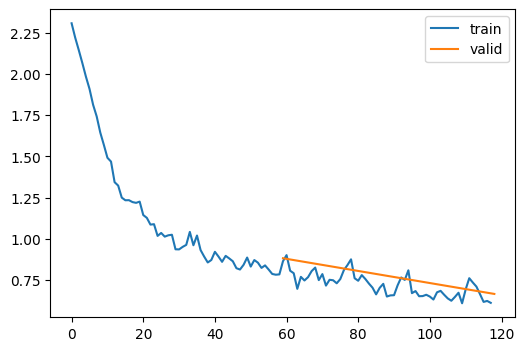

In [14]:
cbs = [TrainCB(), DeviceCB(), MetricsCB(accuracy=MulticlassAccuracy(num_classes)), ProgressCB(plot=True)]
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(2)

Given that TrainCB was almost useless cuz you want it almost every time you can subclass the Learner and instead of
getting predict(), get_loss() etc from cbs you just directly implement them as class method subclassing the learner directly instead of every time registering the TrainCB

In [15]:
#|export
class TrainLearner(Learner):
    
    # since these methods are here defined Learner.__getattr__(self, name) is not called    
    
    def predict(self): 
        self.preds = self.model(self.batch[0])
        
    def get_loss(self): 
        self.loss = self.loss_func(self.preds, self.batch[1])
        
    def backward(self): 
        self.loss.backward()
        
    def step(self): 
        self.opt.step()
        
    def zero_grad(self): 
        self.opt.zero_grad()        

In [16]:
#|export
class MomentumLearner(TrainLearner):
    
    '''    
    IDEA: instead of zeroing gradients we keep them "alive" but we shrink them by a factor "momentum" < 1
    NB: PyTorch autograd ONLY ADDS to gradients
    '''
    
    def __init__(self, model, dls, loss_func, lr=None, cbs=None, opt_func=optim.SGD, mom=0.85):
        self.mom = mom
        super().__init__(model, dls, loss_func, lr, cbs, opt_func)

    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters(): 
                p.grad *= self.mom

accuracy,loss,epoch,train
0.678,0.939,0,train
0.782,0.620,0,eval
0.818,0.521,1,train
0.812,0.536,1,eval


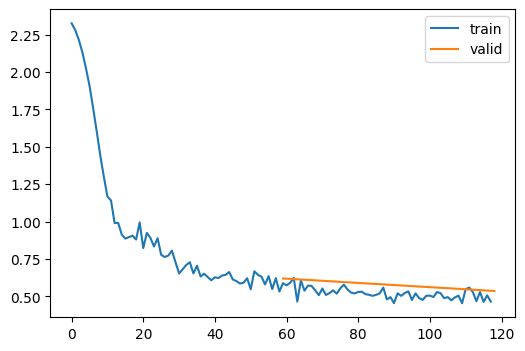

In [17]:
# NB: No TrainCB
metrics = MetricsCB(accuracy=MulticlassAccuracy(num_classes))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.1, cbs=cbs)
learn.fit(2)

In [18]:
#|export
from torch.optim.lr_scheduler import ExponentialLR

class LRFinderCB(Callback):
    
    '''
    Increase lr over time and plot it against the loss and then we find how high we can bring the lr b4 loss gets to inf    
    lr desired = value on x-axis where slope is the steepest before loss explodes
    
    The scheduler multipliers the lr of all params in model by a factor gamma taken as input by the scheduler. 
    The multiplication occurs only when scheduler.step() is called.
    
    LR finder is only a rough guide in any situation - generally you’ll want to try around 4x lower and 4x higher LRs too.
    '''
    
    def __init__(self, gamma=1.3, max_mult=3): 
        fc.store_attr()
    
    def before_fit(self, learn):
        self.sched = ExponentialLR(learn.opt, self.gamma)
        self.lrs,self.losses = [],[]
        self.min = math.inf

    def after_batch(self, learn):
        if not learn.training: 
            raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: 
            self.min = loss
        if math.isnan(loss) or (loss > self.min*self.max_mult): # stopping criteria
            raise CancelFitException()
        self.sched.step()
        # last line equivalent of:
        # for g in self.learner.opt.param_groups:
        #     g['lr'] *= self.lr_multiplier

    def cleanup_fit(self, learn):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

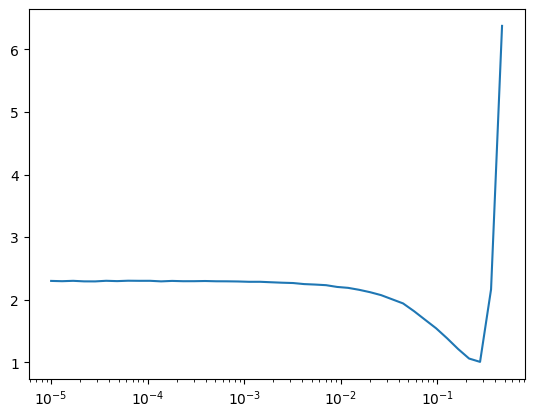

In [19]:
cbs = [DeviceCB()]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-5, cbs=cbs)
learn.fit(3, cbs=LRFinderCB())

In [1]:
# @fc.patch allows you to define a func (lr_find() here below) and transform it
# to be a method of the class passed as input (self:Learner; or better of 
# whatever class comes after the :) -> so it can call fit with a particular 
# set of params.
# Nice cuz creates a callable temp version for fit to find lr 

@fc.patch
def lr_find(self:Learner, gamma=1.3, max_mult=3, start_lr=1e-5, max_epochs=10):
    self.fit(max_epochs, lr=start_lr, cbs=LRFinderCB(gamma=gamma, max_mult=max_mult))

MomentumLearner(get_model(), dls, F.cross_entropy, cbs=cbs).lr_find()

NameError: name 'fc' is not defined

In [1]:
#import nbdev; nbdev.nbdev_export()